<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploration-de-la-base-de-données" data-toc-modified-id="Exploration-de-la-base-de-données-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploration de la base de données</a></span><ul class="toc-item"><li><span><a href="#Importation-des-modules" data-toc-modified-id="Importation-des-modules-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importation des modules</a></span></li><li><span><a href="#Importation-du-dataset-et-premières-remarques" data-toc-modified-id="Importation-du-dataset-et-premières-remarques-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importation du dataset et premières remarques</a></span></li><li><span><a href="#Durée-du-mandat-des-députés" data-toc-modified-id="Durée-du-mandat-des-députés-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Durée du mandat des députés</a></span></li></ul></li><li><span><a href="#Y-a-t-il-des-doublons ?" data-toc-modified-id="Y-a-t-il-des-doublons ?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Y a-t-il des doublons ?</a></span><ul class="toc-item"><li><span><a href="#Évolution-temporelle" data-toc-modified-id="Évolution-temporelle-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Évolution temporelle</a></span></li><li><span><a href="#Doublons-par-député…" data-toc-modified-id="Doublons-par-député…-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Doublons par député…</a></span></li><li><span><a href="#Doublons-par-entreprise" data-toc-modified-id="Doublons-par-entreprise-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Doublons par entreprise</a></span></li><li><span><a href="#Doublons-par-parti" data-toc-modified-id="Doublons-par-parti-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Doublons par parti</a></span></li></ul></li><li><span><a href="#Les-surfacturations" data-toc-modified-id="Les-surfacturations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Les surfacturations</a></span><ul class="toc-item"><li><span><a href="#Surfacturation-par-entreprise" data-toc-modified-id="Surfacturation-par-entreprise-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Surfacturation par entreprise</a></span></li><li><span><a href="#Surfacturation-par-député" data-toc-modified-id="Surfacturation-par-député-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Surfacturation par député</a></span></li><li><span><a href="#Surfacturation-par-parti" data-toc-modified-id="Surfacturation-par-parti-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Surfacturation par parti</a></span></li></ul></li><li><span><a href="#Relation-entre-les-doublons-et-les-surfacturations" data-toc-modified-id="Relation-entre-les-doublons-et-les-surfacturations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Relation entre les doublons et les surfacturations</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
# Brazil's House of Deputies Reimbursements

Dans ce document, je propose d’étudier une base de données qui a trait aux factures enregistrées par les députés brésiliens.

In [ ]:
En dessous, en anglais, le texte qui accompagnait le dataset :
    
Acknowledgments:

This data is from dadosabertos.camara.leg.br

** Inspiration:**

I have only slightly fiddled with the dataset, but there are some funny patterns to say the least.
Brazil faces a huge problem with corruption and neglect with public funds, this dataset helps to show that.

I invite fellow kagglers to toy with the dataset, try to identify suspicious spendings as well as odd patterns.

bugged_date: (binary) identify whether date had issues
receipt_date: (datetime) receipt date // (int year) for when bugged_date == 1
deputy_id: (deputy_id) id number. (didnt check if it changed across year/legislation period for deputies)
political_party: (string) deputy political party
state_code: (string) Brazil's state that elected the deputy
deputy_name: (string)
receipt_social_security_number: might be a persons SS number (11 digits long) or a business id number (14 digits long). Many cases with issues.
receipt_description: (str / classes) class of spending under which the receipt fits
establishment_name: (string)
receipt_value: (int) $BR, 3BR$ ~ 1USD

# Exploration de la base de données

## Importation des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Importation du dataset et premières remarques

J’importe et j’explore le dataset intitulé “Brazil’s House of Deputies Reimbursements” (“Remboursement des frais de la Chambre des Députés du Brésil”).

In [2]:
df = pd.read_parquet('deputies_dataset.parquet')

La première chose que je fais est de vérifier s’il y a des valeurs manquantes.

In [43]:
df.isna().sum()

bugged_date                            0
receipt_date                           0
deputy_id                              0
political_party                        0
state_code                             0
deputy_name                            0
receipt_social_security_number    520952
receipt_description                    0
establishment_name                     0
receipt_value                          0
dtype: int64

Il y a un certain nombre de valeurs manquantes dans la colonne “receipt_social_security_number”…
Que représentent-ils dans le dataset ?

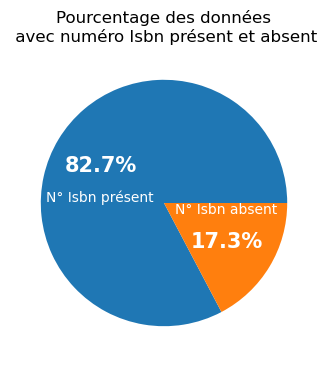

In [6]:
plt.figure(figsize = (4, 4))
secteurs, textes, pourcentages = plt.pie(df['receipt_social_security_number'].isna().value_counts(),
        labels = ['N° Isbn présent', 'N° Isbn absent'], autopct = '%.1f%%',
       labeldistance = 0.1)
plt.setp(pourcentages, fontweight = "bold", color = "white", fontsize = 15)
plt.setp(textes, color = "white")
plt.title("Pourcentage des données\n avec numéro Isbn présent et absent");

Ces nombres Isbn manquants sont en nombre important : je les garde.

In [43]:
# Je regarde le type des colonnes et l’occupation de la mémoire
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014902 entries, 0 to 3014901
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   bugged_date                     int64  
 1   receipt_date                    object 
 2   deputy_id                       int64  
 3   political_party                 object 
 4   state_code                      object 
 5   deputy_name                     object 
 6   receipt_social_security_number  float64
 7   receipt_description             object 
 8   establishment_name              object 
 9   receipt_value                   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.3 GB


Un certain nombre de colonnes ont pour type “Object”.
Je vais faire des conversions dans le type approprié.
Mais avant cela je vais regarder comment sont ces “bugged_date”…

In [7]:
df.loc[df['bugged_date'] == True, "receipt_date"]

102        2013
107        2013
108        2013
126        2013
127        2013
           ... 
3008451    2009
3012983    2009
3013142    2009
3014370    2009
3014650    2009
Name: receipt_date, Length: 49531, dtype: object

Il n’y a que l’année qui est renseigné… C’est la raison pour laquelle lors d’une conversion en type
datetime, elles sont ajoutées au premier janvier.

Y a-t-il d’autres enregistrements signalés comme non-buggués qui ont cette caractéristique ?

In [64]:
df.loc[df['bugged_date'] == False, "receipt_date"].str.match("^\d{4}$").sum()

0

Apparemment non.

In [ ]:
# Cette base de données couvre-t-elle quelle période de temps ?

In [8]:
(df.loc[df['bugged_date'] == False, 'receipt_date'].min(), df.loc[df['bugged_date'] == False, 'receipt_date'].max())

(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-10-24 17:56:47'))

Les enregistrements vont du 1ᵉʳ janvier 2009 au 24 octobre 2017.

À présent, je fais des conversions pour alléger le dataset

In [3]:
df['receipt_social_security_number'] = df['receipt_social_security_number'].astype('Int64')

df['receipt_date'] = pd.to_datetime(df['receipt_date'])

# Je transforme les données de type “object” en type “string”
col_string = df.select_dtypes('object')
df[col_string.columns] = col_string.astype('string')

In [97]:
# Je vérifie que la base de données a bien diminué en poids…
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014902 entries, 0 to 3014901
Data columns (total 10 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   bugged_date                     int64         
 1   receipt_date                    datetime64[ns]
 2   deputy_id                       int64         
 3   political_party                 string        
 4   state_code                      string        
 5   deputy_name                     string        
 6   receipt_social_security_number  Int64         
 7   receipt_description             string        
 8   establishment_name              string        
 9   receipt_value                   int64         
dtypes: Int64(1), datetime64[ns](1), int64(3), string(5)
memory usage: 232.9 MB


In [30]:
# Étendue de la variable “receipt_value”, le montant des factures

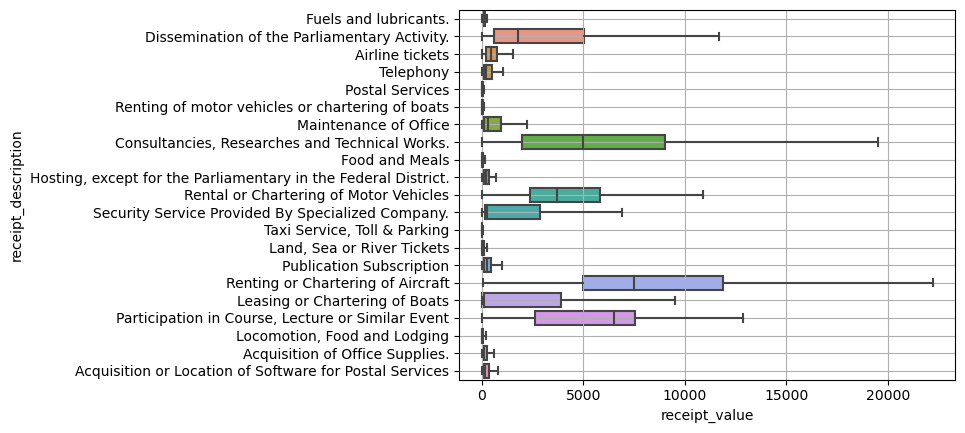

In [7]:
# Sans les outliers
sns.boxplot(data = df, y = 'receipt_description', x = 'receipt_value', showfliers = False)
plt.grid()

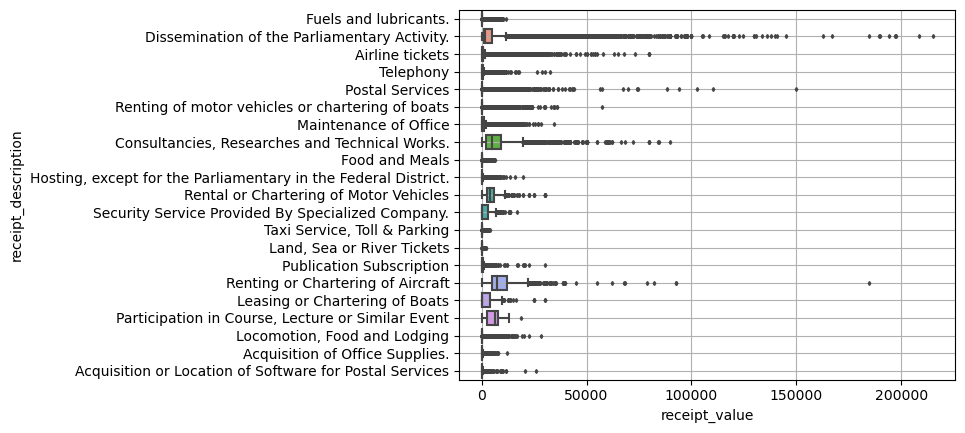

In [8]:
# Avec les outliers
sns.boxplot(data = df, y = 'receipt_description', x = 'receipt_value', fliersize = 2)
plt.grid()

Les “points noirs” sont toutes les valeurs au-delà de la valeur limite raisonnable (la valeur du troisième quartile additionnée de l’écart-interquartile fois 1.5)

Il y a beaucoup de valeurs atypiques… et la différence entre les valeurs maximales normales et les valeurs atypiques est énorme. Par exemple, dans le poste “Airline tickets“ (Billets d’avion), la valeur maximale normale est :

In [5]:
group_billets_avion = df.groupby('receipt_description').get_group('Airline tickets')

print(f'Le troisième quartile est', group_billets_avion["receipt_value"].quantile(0.75), end = ' ')
print(f'tandis que l’espace interquartile est de :',
      group_billets_avion["receipt_value"].quantile(0.75) -  group_billets_avion["receipt_value"].quantile(0.25))
print('Soit une valeur maximale normale de : 1292 dollars brésiliens')
print(' ')
print('La distribution des outliers, les valeurs supérieures à la valeur maximale normale est:')

Le troisième quartile est 762.0 tandis que l’espace interquartile est de : 530.0
Soit une valeur maximale normale de : 1292 dollars brésiliens
 
La distribution des outliers, les valeurs supérieures à la valeur maximale normale est:


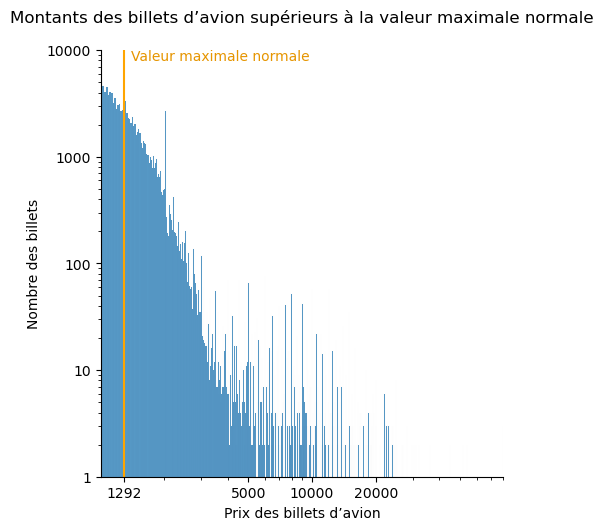

In [10]:
sns.displot(group_billets_avion[group_billets_avion["receipt_value"] > 1000]['receipt_value'])
plt.axvline(x = 1292, color = 'orange')
plt.xlabel('Prix des billets d’avion')
plt.ylabel('Nombre des billets')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 10000])
plt.annotate('Valeur maximale normale', xy = (1400, 8000), xycoords = 'data', color = '#e69500')
plt.title('Montants des billets d’avion supérieurs à la valeur maximale normale', pad = 20)
plt.margins(0)

ax = plt.gca()
ax.set_xticks([1292, 5000, 10000, 20000])
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

Certains billets sont plus de 10 fois supérieur au prix maximal normal…

Avec les doublons, c’est un autre axe de recherche.

## Durée du mandat des députés

Le premier enregistrement aurait eu lieu le 1er janvier 2009 et le dernier, le 24 octobre 2017.

Il manque le nombre de jours présents de chaque député à la députation pour pouvoir comparer les sommes dépensées.
Puis-je le déduire ? Est-ce que les temps de députation sont continus ou discontinus ? Les élections législatives ont lieu tous les quatre ans au Brésil. Leurs dates sont le 5 octobre 2014, le 7 octobre 2018 et le 3 octobre 2010.
Je vais considérer que dès qu’un député commence à travailler, il se met à avoir des frais…

In [16]:
# Je vais d’abord ajouter une colonne “nb_exemplaires”
# pour compter pour chaque facture le nombre de fois où elle est présente
(
    df := df.groupby(df.columns.tolist(), as_index = False, dropna = False).size()\
    .sort_values(by = 'size', ascending = False).rename(columns = {'size': 'nb_exemplaires'})
)

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,nb_exemplaires
144084,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,44
1276717,0,2012-12-31,1744,PODE,MG,Ademir Camilo,7575651000159,Airline tickets,Cia Aérea - GOL,106,44
1934312,0,2015-02-25,1703,PR,PB,Wellington Roberto,2012862000160,Airline tickets,Cia Aérea - TAM,296,39
574629,0,2010-12-27,1332,PHS,AL,Givaldo Carimbão,2012862000160,Airline tickets,Cia Aérea - TAM,336,37
575167,0,2010-12-28,1531,PCDOB,BA,Alice Portugal,7575651000159,Airline tickets,Cia Aérea - GOL,218,36
...,...,...,...,...,...,...,...,...,...,...,...
964262,0,2012-02-04,1650,PSD,MG,Geraldo Thadeu,1116974000106,Fuels and lubricants.,LARANJÃO EMPREENDIMENTOS LTDA.,42,1
964263,0,2012-02-04,1650,PSD,MG,Geraldo Thadeu,3418121000146,Fuels and lubricants.,ALFA RVM LTDA.,30,1
964264,0,2012-02-04,1650,PSD,MG,Geraldo Thadeu,<NA>,Telephony,RAMAL,351,1
964265,0,2012-02-04,1651,PR,PR,Giacobo,2331276000188,Fuels and lubricants.,POSTO DAS AMERICAS LTDA,421,1


In [17]:
# Et je vais utiliser une portion du dataset plus réduite.
# D’abord je laisse tomber les dates bugguées.
# Et ensuite je trie le tableau par député et par date
df_dates = df[df['bugged_date'] == False][['receipt_date', 'deputy_name', 'political_party']]\
.sort_values(['deputy_name', 'political_party', 'receipt_date'])

In [276]:
# J’enlève les lignes dupliquées

In [18]:
(
    df_dates := df_dates.drop_duplicates()
)

,receipt_date,deputy_name,political_party
1906136,2015-01-09 00:00:00,Abel Mesquita Jr.,DEM
1918550,2015-02-02 00:00:00,Abel Mesquita Jr.,DEM
1920694,2015-02-04 00:00:00,Abel Mesquita Jr.,DEM
1921943,2015-02-05 00:00:00,Abel Mesquita Jr.,DEM
1922864,2015-02-06 00:00:00,Abel Mesquita Jr.,DEM
...,...,...,...
1904068,2015-01-05 14:52:35,Íris De Araújo,PMDB
1907548,2015-01-13 00:00:00,Íris De Araújo,PMDB
1908326,2015-01-14 00:00:00,Íris De Araújo,PMDB
1910444,2015-01-19 00:00:00,Íris De Araújo,PMDB


À partir du dataset réduit constitué uniquement de la date, du nom du député et de son parti,
je vais créer les colonnes “date_suivante” (la date suivante), “minimum” (la date du premier enregistrement),
“maximum” (la date du dernier enregistrement).

In [19]:
df_dates['date_suivante'] = df_dates.groupby(['deputy_name', 'political_party'])['receipt_date'].transform(lambda x : x.shift(-1))

In [21]:
df_dates['minimum'] = df_dates.groupby(['deputy_name', 'political_party'])['receipt_date'].transform('min')

In [23]:
df_dates['maximum'] = df_dates.groupby(['deputy_name', 'political_party'])['receipt_date'].transform('max')

In [24]:
df_dates

,receipt_date,deputy_name,political_party,date_suivante,minimum,maximum
1906136,2015-01-09 00:00:00,Abel Mesquita Jr.,DEM,2015-02-02 00:00:00,2015-01-09,2017-10-05 00:00:00
1918550,2015-02-02 00:00:00,Abel Mesquita Jr.,DEM,2015-02-04 00:00:00,2015-01-09,2017-10-05 00:00:00
1920694,2015-02-04 00:00:00,Abel Mesquita Jr.,DEM,2015-02-05 00:00:00,2015-01-09,2017-10-05 00:00:00
1921943,2015-02-05 00:00:00,Abel Mesquita Jr.,DEM,2015-02-06 00:00:00,2015-01-09,2017-10-05 00:00:00
1922864,2015-02-06 00:00:00,Abel Mesquita Jr.,DEM,2015-02-09 00:00:00,2015-01-09,2017-10-05 00:00:00
...,...,...,...,...,...,...
1904068,2015-01-05 14:52:35,Íris De Araújo,PMDB,2015-01-13 00:00:00,2009-03-18,2015-01-26 16:16:05
1907548,2015-01-13 00:00:00,Íris De Araújo,PMDB,2015-01-14 00:00:00,2009-03-18,2015-01-26 16:16:05
1908326,2015-01-14 00:00:00,Íris De Araújo,PMDB,2015-01-19 00:00:00,2009-03-18,2015-01-26 16:16:05
1910444,2015-01-19 00:00:00,Íris De Araújo,PMDB,2015-01-26 16:16:05,2009-03-18,2015-01-26 16:16:05


In [25]:
# Et je calcule l’intervalle entre chaque date de facture pour chaque député
# et je m’attarde sur les intervalles supérieures à quatre ans (la durée d’un mandat).

quatre_ans = pd.Timedelta("1460 days")

Je vais ajouter une colonne interruption qui me signalera une interruption de plus de quatre ans

In [26]:
df_group_deputy_party  = df_dates.groupby(['deputy_name', 'political_party'])
df_dates['difference'] = df_group_deputy_party['receipt_date'].transform(lambda x : x.shift(-1) - x)

In [27]:
display(df_dates)

,receipt_date,deputy_name,political_party,date_suivante,minimum,maximum,difference
1906136,2015-01-09 00:00:00,Abel Mesquita Jr.,DEM,2015-02-02 00:00:00,2015-01-09,2017-10-05 00:00:00,24 days 00:00:00
1918550,2015-02-02 00:00:00,Abel Mesquita Jr.,DEM,2015-02-04 00:00:00,2015-01-09,2017-10-05 00:00:00,2 days 00:00:00
1920694,2015-02-04 00:00:00,Abel Mesquita Jr.,DEM,2015-02-05 00:00:00,2015-01-09,2017-10-05 00:00:00,1 days 00:00:00
1921943,2015-02-05 00:00:00,Abel Mesquita Jr.,DEM,2015-02-06 00:00:00,2015-01-09,2017-10-05 00:00:00,1 days 00:00:00
1922864,2015-02-06 00:00:00,Abel Mesquita Jr.,DEM,2015-02-09 00:00:00,2015-01-09,2017-10-05 00:00:00,3 days 00:00:00
...,...,...,...,...,...,...,...
1904068,2015-01-05 14:52:35,Íris De Araújo,PMDB,2015-01-13 00:00:00,2009-03-18,2015-01-26 16:16:05,7 days 09:07:25
1907548,2015-01-13 00:00:00,Íris De Araújo,PMDB,2015-01-14 00:00:00,2009-03-18,2015-01-26 16:16:05,1 days 00:00:00
1908326,2015-01-14 00:00:00,Íris De Araújo,PMDB,2015-01-19 00:00:00,2009-03-18,2015-01-26 16:16:05,5 days 00:00:00
1910444,2015-01-19 00:00:00,Íris De Araújo,PMDB,2015-01-26 16:16:05,2009-03-18,2015-01-26 16:16:05,7 days 16:16:05


In [28]:
df_dates['interruption'] = df_dates.groupby(['deputy_name', 'political_party'])['difference']\
.transform(lambda x : x > quatre_ans)

In [29]:
df_dates

,receipt_date,deputy_name,political_party,date_suivante,minimum,maximum,difference,interruption
1906136,2015-01-09 00:00:00,Abel Mesquita Jr.,DEM,2015-02-02 00:00:00,2015-01-09,2017-10-05 00:00:00,24 days 00:00:00,False
1918550,2015-02-02 00:00:00,Abel Mesquita Jr.,DEM,2015-02-04 00:00:00,2015-01-09,2017-10-05 00:00:00,2 days 00:00:00,False
1920694,2015-02-04 00:00:00,Abel Mesquita Jr.,DEM,2015-02-05 00:00:00,2015-01-09,2017-10-05 00:00:00,1 days 00:00:00,False
1921943,2015-02-05 00:00:00,Abel Mesquita Jr.,DEM,2015-02-06 00:00:00,2015-01-09,2017-10-05 00:00:00,1 days 00:00:00,False
1922864,2015-02-06 00:00:00,Abel Mesquita Jr.,DEM,2015-02-09 00:00:00,2015-01-09,2017-10-05 00:00:00,3 days 00:00:00,False
...,...,...,...,...,...,...,...,...
1904068,2015-01-05 14:52:35,Íris De Araújo,PMDB,2015-01-13 00:00:00,2009-03-18,2015-01-26 16:16:05,7 days 09:07:25,False
1907548,2015-01-13 00:00:00,Íris De Araújo,PMDB,2015-01-14 00:00:00,2009-03-18,2015-01-26 16:16:05,1 days 00:00:00,False
1908326,2015-01-14 00:00:00,Íris De Araújo,PMDB,2015-01-19 00:00:00,2009-03-18,2015-01-26 16:16:05,5 days 00:00:00,False
1910444,2015-01-19 00:00:00,Íris De Araújo,PMDB,2015-01-26 16:16:05,2009-03-18,2015-01-26 16:16:05,7 days 16:16:05,False


In [ ]:
# Combien y a-t-il eu d’interruption de plus de quatre ans dans le dataset ?

In [30]:
df_dates['interruption'].sum()

8

In [ ]:
# Pour 8 députés, il y a une interruption dans la députation.

In [31]:
df_dates[df_dates['interruption']]

,receipt_date,deputy_name,political_party,date_suivante,minimum,maximum,difference,interruption
596273,2011-01-31 00:00:00,Alberto Fraga,DEM,2015-02-18,2009-08-26,2017-10-23 00:00:00,1479 days 00:00:00,True
596682,2011-01-31 00:00:00,Laerte Bessa,PR,2015-02-10,2009-02-20,2017-10-20 00:00:00,1471 days 00:00:00,True
619439,2011-02-23 00:00:00,Maia Filho,PP,2015-05-12,2009-03-02,2017-10-16 00:00:00,1539 days 00:00:00,True
174182,2009-10-20 00:00:00,Odelmo Leão,PP,2015-02-01,2009-10-20,2016-12-28 16:01:58,1930 days 00:00:00,True
619346,2011-02-23 00:00:00,Rocha Loures,PMDB,2017-03-30,2009-01-26,2017-06-28 00:00:00,2227 days 00:00:00,True
575899,2010-12-29 10:47:12,Rômulo Gouveia,PSD,2015-02-01,2009-03-27,2017-10-08 00:00:00,1494 days 13:12:48,True
597985,2011-02-01 00:00:00,Vinicius Carvalho,PRB,2015-02-01,2009-01-08,2017-10-24 17:10:08,1461 days 00:00:00,True
596896,2011-01-31 00:00:00,William Woo,PP,2015-02-09,2009-02-07,2016-05-12 00:00:00,1470 days 00:00:00,True


In [32]:
# Je transforme df_dates['difference'] en entier
df_dates['difference'] = df_dates['difference'].astype(str)

df_dates['difference'] = df_dates['difference'].str.extract('(^[0-9]+)').astype('Int32')

In [ ]:
Je vais sélectionner les députés qui sont concernés par cette interruption de mandat

In [34]:
deputes_interruption = df_dates.loc[df_dates['interruption'], 'deputy_name']

In [35]:
deputes_interruption

596273        Alberto Fraga
596682         Laerte Bessa
619439           Maia Filho
174182          Odelmo Leão
619346         Rocha Loures
575899       Rômulo Gouveia
597985    Vinicius Carvalho
596896          William Woo
Name: deputy_name, dtype: string

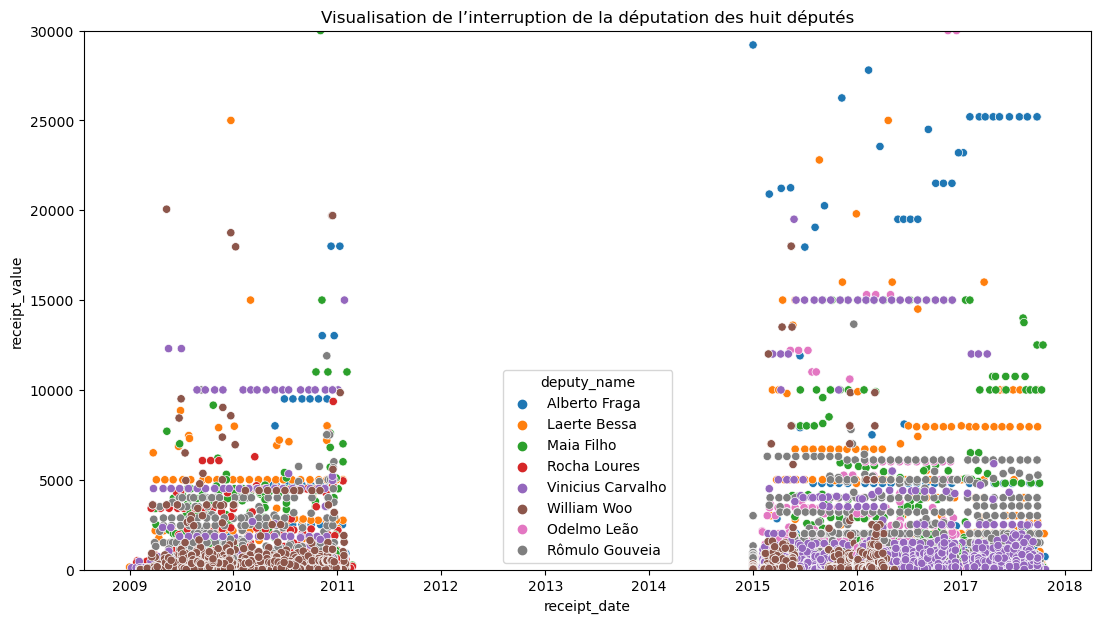

In [75]:
# Visualisation de l’interruption
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 7))
sns.scatterplot(df.query('deputy_name.isin(@deputes_interruption)'),
                x = 'receipt_date', y = 'receipt_value', hue = 'deputy_name', ax = ax)
plt.ylim([0, 30000])
plt.title('Visualisation de l’interruption de la députation des huit députés');

Pour ces huit députés, je mets la date lors de l’interruption dans une fin “fin_de premier_mandat” et
la date suivant l’interruption dans une colonne “deb_deuxième mandat”

In [36]:
for depute in deputes_interruption:
    fin_premier_mandat = df_dates.loc[(df_dates['deputy_name'] == depute) & df_dates['interruption'], 'receipt_date'].values[0]
    df_dates.loc[df_dates['deputy_name'] == depute, 'fin_premier_mandat'] = fin_premier_mandat

for depute in deputes_interruption:
    debut_deuxieme_mandat = df_dates.loc[(df_dates['deputy_name'] == depute) & df_dates['interruption'], 'date_suivante'].values[0]
    df_dates.loc[df_dates['deputy_name'] == depute, 'deb_deuxieme_mandat'] = debut_deuxieme_mandat

Je vais donc faire la somme de la première période jusqu’à l’interruption et de la deuxième période à partir
de la reprise des factures pour ces huit députés.
Pour tous les autres, je vais faire la différence entre la date maximum et la date minimum
pour connaître leur nombre de jours de présence en tant que député.

In [41]:
df_dates['periode'] = np.where(df_dates['deputy_name'].isin(deputes_interruption),
                               (df_dates['fin_premier_mandat'] - df_dates['minimum']) +\
                               (df_dates['maximum'] - df_dates['deb_deuxieme_mandat']),
                               df_dates['maximum'] - df_dates['minimum'])

Je simplifie le dataframe contenant la période de députation avant de le fusionner avec le dataframe principal.

In [42]:
df_dates = df_dates[['deputy_name', 'political_party', 'periode',
                     'minimum', 'fin_premier_mandat', 'deb_deuxieme_mandat', 'maximum']]

df_dates = df_dates.drop_duplicates().set_index(['deputy_name', 'political_party'])

In [44]:
# Je vais transformer la période en entier.

df_dates['periode'] = df_dates['periode'].astype('str').str.extract('(^\d+)').astype('Int32')

In [47]:
df_dates

,,periode,minimum,fin_premier_mandat,deb_deuxieme_mandat,maximum
deputy_name,political_party,,,,,
Abel Mesquita Jr.,DEM,1000,2015-01-09,NaT,NaT,2017-10-05 00:00:00
Abelardo Camarinha,PSB,2095,2009-05-04,NaT,NaT,2015-01-28 12:48:43
Abelardo Lupion,DEM,2219,2009-01-02,NaT,NaT,2015-01-30 17:05:41
Acelino Popó,PRB,1455,2011-02-04,NaT,NaT,2015-01-29 00:00:00
Acácio Júnior,PSB,12,2011-01-19,NaT,NaT,2011-01-31 00:00:00
...,...,...,...,...,...,...
Átila A. Nunes,PMDB,22,2016-01-27,NaT,NaT,2016-02-18 00:00:00
Átila Lins,PSD,3107,2009-04-07,NaT,NaT,2017-10-09 00:00:00
Átila Lira,PSB,3141,2009-03-06,NaT,NaT,2017-10-11 14:32:45


In [48]:
# Et j’ajoute la période de députation au dataframe

In [50]:
(df := df.merge(df_dates, on = ['deputy_name', 'political_party']))

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,nb_exemplaires,periode,minimum,fin_premier_mandat,deb_deuxieme_mandat,maximum
0,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,44,705,2009-03-18,NaT,NaT,2011-02-21
1,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,261,31,705,2009-03-18,NaT,NaT,2011-02-21
2,0,2009-11-24,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,16,705,2009-03-18,NaT,NaT,2011-02-21
3,0,2010-12-28,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,198,12,705,2009-03-18,NaT,NaT,2011-02-21
4,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,308,11,705,2009-03-18,NaT,NaT,2011-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845639,0,2012-07-28,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,RAMAL,41,1,166,2012-05-19,NaT,NaT,2012-11-01
2845640,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,41470063000199,Dissemination of the Parliamentary Activity.,GRÁFICA E EDITORA NORTESUL LTDA,36000,1,166,2012-05-19,NaT,NaT,2012-11-01
2845641,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,CELULAR FUNCIONAL,126,1,166,2012-05-19,NaT,NaT,2012-11-01
2845642,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,IMÓVEL FUNCIONAL,273,1,166,2012-05-19,NaT,NaT,2012-11-01


In [96]:
# Classement des partis selon le temps de présence de leur députés

In [51]:
df.groupby('political_party')['periode'].sum().sort_values(ascending = False)

political_party
PT                       988591555
PMDB                     838438270
PSDB                     619053730
PP                       561311363
PR                       414032624
PSD                      412971912
PSB                      362945475
DEM                      355706905
PDT                      224285792
PTB                      199685946
PCDOB                    175729103
PRB                      171974133
SD                       170897413
PPS                      109719764
PSC                      106327393
PV                        97890355
PSOL                      77924886
PROS                      69626127
PODE                      50412898
PHS                       48832883
AVANTE                    46034375
PEN                       30337322
REDE                      29197429
PSL                       28022750
S.PART.                   17653128
PMN                       10352263
SEM PARTIDO ASSOCIADO      6642072
PRP                        5155272
PTDO

# Y a-t-il des doublons ?

In [138]:
df.groupby(df['nb_exemplaires'] > 1).size().rename({True: 'Factures avec doublons', False : 'Factures uniques'})

nb_exemplaires
Factures uniques          2727602
Factures avec doublons     118042
dtype: int64

In [139]:
print("Il y a 118042 factures avec des doublons.")

Il y a 118042 factures avec des doublons.


In [ ]:
# D’abord, quelle est la proportion de doublons par rapport à ceux qui sont en unique exemplaire ?

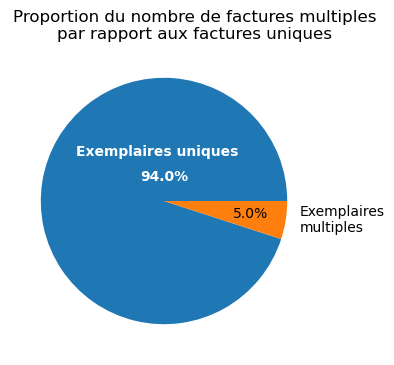

In [637]:
plt.figure(figsize = (6, 4))
portions, textes, percents = plt.pie((df['nb_exemplaires'] > 1).value_counts(),
                                  labels = ['Exemplaires uniques', 'Exemplaires\nmultiples'], 
                                  labeldistance = 1.1, autopct = '%d.0%%')
plt.title('Proportion du nombre de factures multiples\npar rapport aux factures uniques', loc = 'center', x = 0.6)
positions_label = [(0.6, 0.4), (1.1, -0.15)]
positions_percent = [(0, 0.2), (0.7, -0.1)]
fontweights = ['bold', 'normal']
colors = ['white', 'black']

for texte, position_label, fontweight, color, percent, position_percent \
in zip(textes, positions_label, fontweights, colors, percents, positions_percent):
    plt.setp(texte, position = position_label, fontweight = fontweight, color = color)
    plt.setp(percent, position = position_percent, fontweight = fontweight, color = color)

Hélas oui. Beaucoup même. Est-ce que si on enlève la date, on se retrouve avec encore plus de doublons ?

In [141]:
print(f"Il y a {df.duplicated(subset = df.columns.drop(['receipt_date'])).sum():,} doublons.")

Il y a 885,975 doublons.


Si on enlève la date, on se retrouve avec dix fois plus de doublons.
Cela dit, il est possible qu’à des dates différentes, deux factures peuvent être identiques… n’est-ce pas ?

## Évolution temporelle

Je vais à présenter étudier l’évolution du phénomène “doublons” au cours du temps.

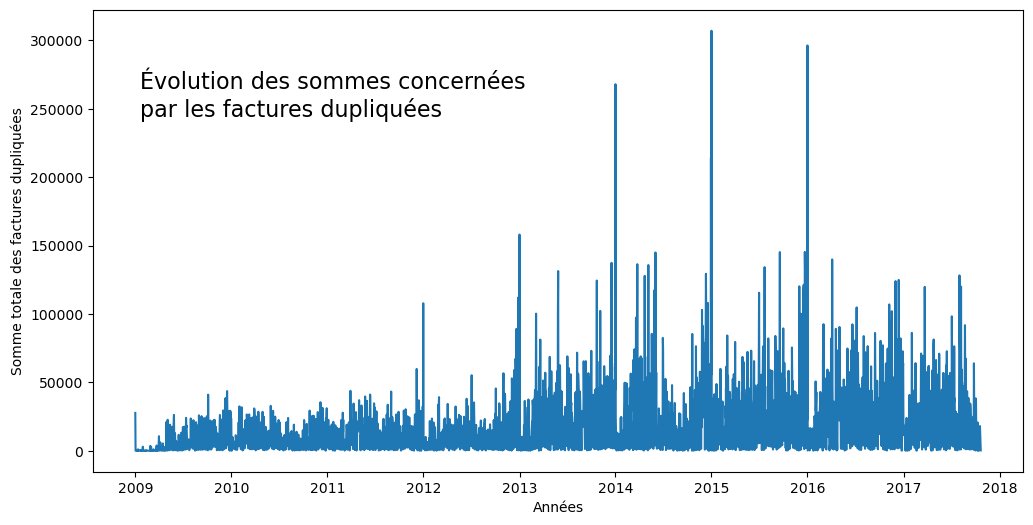

In [144]:
plt.figure(figsize = (12, 6))
plt.plot(df[df['nb_exemplaires'] > 1].set_index('receipt_date').resample('D')['receipt_value'].sum())
plt.xlabel('Années')
plt.ylabel('Somme totale des factures dupliquées')
plt.title("Évolution des sommes concernées\npar les factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

On constate que le phénomène des “factures dupliquées” s’est amplifié au cours du temps,
et notamment à partir 2013…

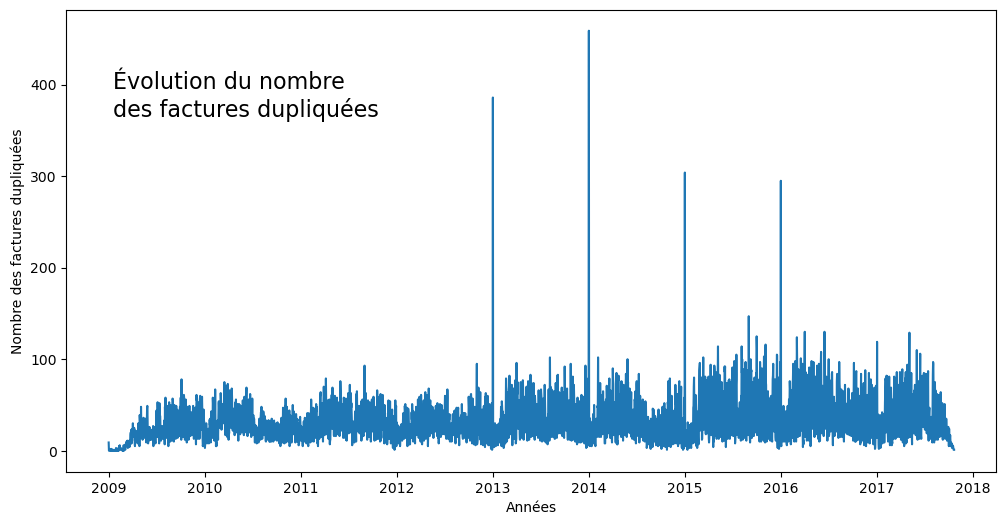

In [145]:
plt.figure(figsize = (12, 6))
plt.plot(df[df['nb_exemplaires'] > 1].set_index('receipt_date').resample('D')['receipt_value'].count())
plt.xlabel('Années')
plt.ylabel('Nombre des factures dupliquées')
plt.title("Évolution du nombre\ndes factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

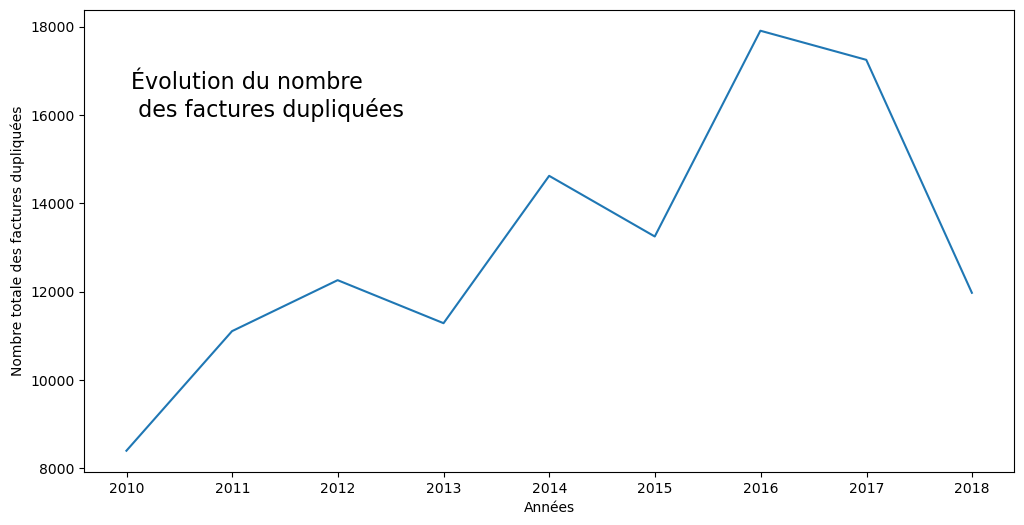

In [147]:
plt.figure(figsize = (12, 6))
plt.plot(df[df['nb_exemplaires'] > 1].set_index('receipt_date').resample('Y')['receipt_value'].count())
plt.xlabel('Années')
plt.ylabel('Nombre totale des factures dupliquées')
plt.yticks()
plt.title("Évolution du nombre \n des factures dupliquées", loc = 'left', x = 0.05, y = 0.75,
         fontsize = 16);

Mais à partir de 2016, il y a de moins en moins de factures dupliquées… Se serait-on attaqué au problème ?

## Doublons par député…

Je vais regarder maintenant le nombre de doublons par député.

In [156]:
(
    factures_dupliquées_député := df[df['nb_exemplaires'] > 1].groupby(['deputy_name'])['nb_exemplaires']\
    .apply(lambda x : (x - 1).sum()).sort_values(ascending = False)
)

deputy_name
Jorge Tadeu Mudalen     4404
Bonifácio De Andrada    2434
Júlio Delgado           2102
Vilson Covatti          1649
Henrique Fontana        1590
                        ... 
Moroni Torgan              1
Jorge Alberto              1
Márcio Biolchi             1
Ernandes Amorim            1
Psol                       1
Name: nb_exemplaires, Length: 1116, dtype: int64

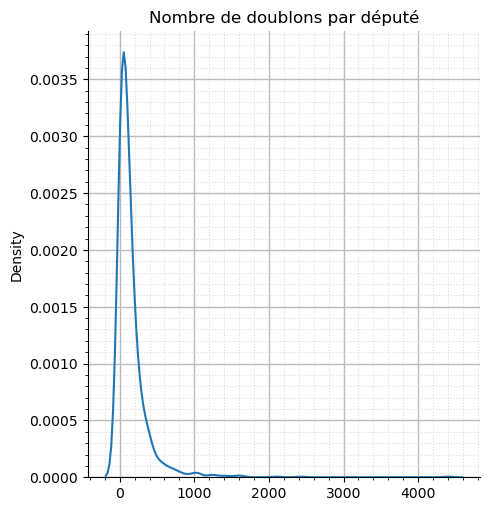

In [557]:
sns.displot(data = factures_dupliquées_député, kind = 'kde')
plt.grid(which = 'major', color = '#BBBBBB', linewidth = 1)
plt.grid(which = 'minor', color = '#DDDDDD', linestyle = ':', linewidth = 0.8)
plt.minorticks_on()
plt.title('Nombre de doublons par député');

On trouve une distribution asymétrique positive avec la plupart des valeurs entre 0 et 500
et une longue queue constituée de milliers de doublons

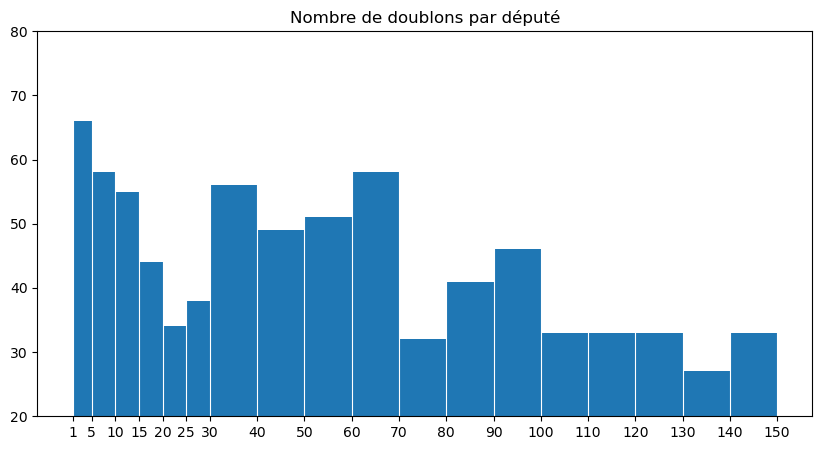

In [559]:
# Je vais utiliser un histogramme
plt.figure(figsize = (10, 5))
n, bins, patches = plt.hist(factures_dupliquées_député[factures_dupliquées_député < 150],
                            bins = [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])
plt.xticks(bins)
plt.ylim([20, 80])
plt.grid(axis = 'x', color = 'white')
plt.title('Nombre de doublons par député');

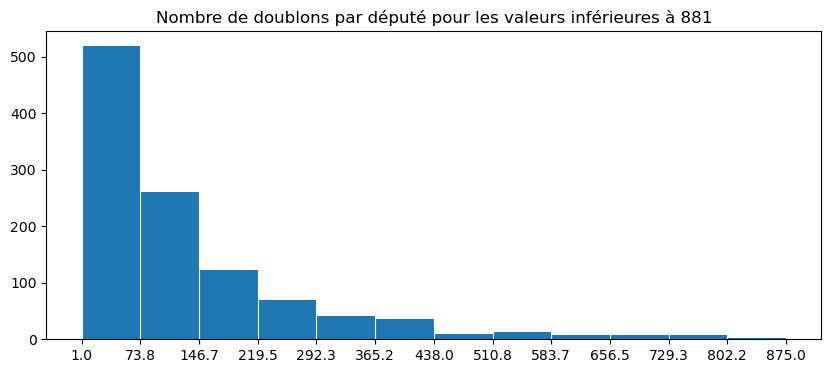

In [558]:
plt.figure(figsize = (10, 4))
n, bins, patches = plt.hist(factures_dupliquées_député[factures_dupliquées_député < 881], bins = 'sturges')
plt.xticks(bins)
plt.grid(axis = 'x', color = 'w')
plt.title('Nombre de doublons par député pour les valeurs inférieures à 881');

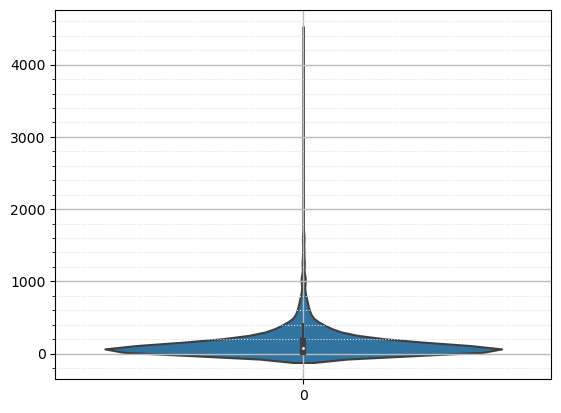

In [24]:
sns.violinplot(data = factures_dupliquées_député)
plt.grid(which = 'major', color = '#BBBBBB', linewidth = 1)
plt.grid(which = 'minor', color = '#DDDDDD', linestyle = ':', linewidth = 0.8)
plt.minorticks_on()

In [560]:
print(f'La médiane des valeurs est {factures_dupliquées_député.median():.0f}.')

La médiane des valeurs est 84.


Ce que l’on retrouve dans le diagramme en violon : on voit que l’ensemble des valeurs sont entre 0 et 438 copies.
Ce qui est déjà beaucoup…

In [ ]:
# Y a-t-il un lien entre le fait qu’une facture soit dupliquée et la présence ou non d’un numéro de sécurité sociale ?

In [72]:
df.loc[df['nb_exemplaires'] > 1, 'receipt_social_security_number'].isna().sum()

0

Et ils ont tous leur numéro de sécurité social renseigné.

In [ ]:
# Et la date bugguée ?

In [78]:
(
    doublons_date_bugguée := df.loc[df['nb_exemplaires'] > 1, 'bugged_date'].value_counts()
)

False    116083
True        274
Name: bugged_date, dtype: int64

In [ ]:
# Et leur date pour la grande majorité est non bugguée.

In [ ]:
# Sont-il plus le fait d’un député, d’une entreprise, d’un parti, d’un état ?

In [ ]:
# Nous avons vu que certains députés ont beaucoup de doublons.

In [89]:
(
doublons_depute := df[df['nb_exemplaires']>1].groupby('deputy_name').agg({'nb_exemplaires': lambda x: (x -1).sum(), 'political_party': lambda x : x.unique()[0]})\
    .rename(columns = {'nb_exemplaires': 'nb_doublons'})
)

,nb_doublons,political_party
deputy_name,,
Abel Mesquita Jr.,254,DEM
Abelardo Camarinha,95,PSB
Abelardo Lupion,77,DEM
Acelino Popó,134,PRB
Acélio Casagrande,34,PMDB
...,...,...
Átila A. Nunes,1,PMDB
Átila Lins,25,PSD
Átila Lira,66,PSB


In [90]:
doublons_depute = doublons_depute.sort_values('nb_doublons', ascending = False)

In [91]:
doublons_depute[:20]

,nb_doublons,political_party
deputy_name,,
Jorge Tadeu Mudalen,4384,DEM
Bonifácio De Andrada,2431,PSDB
Júlio Delgado,2102,PSB
Vilson Covatti,1648,PP
Henrique Fontana,1580,PT
Nelson Meurer,1564,PP
Pepe Vargas,1417,PT
Marco Maia,1407,PT
Vanderlei Macris,1293,PSDB


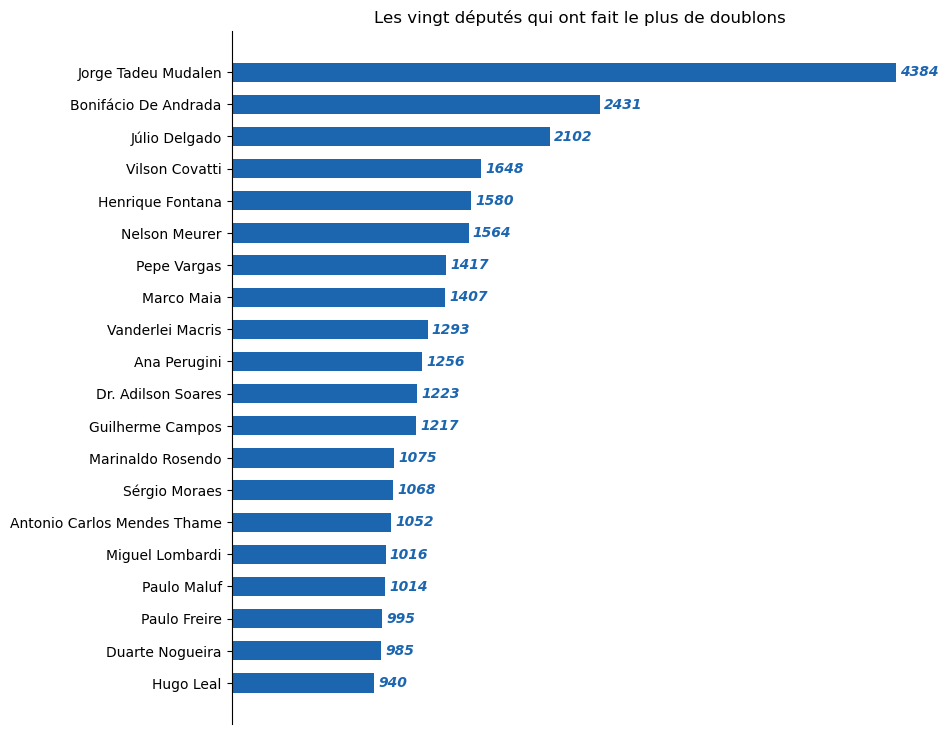

In [93]:
fig, ax = plt.subplots(figsize = (9, 9))
bars = ax.barh(y = list(reversed(doublons_depute[:20].index)),
         width = list(reversed(doublons_depute[:20]['nb_doublons'])), height = 0.6, color = '#1c66b0')
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bars, padding = 3, label_type = 'edge', fontstyle = 'italic', color = '#1c66b0',
            fontweight = 'bold')
plt.title('Les vingt députés qui ont fait le plus de doublons');

In [ ]:
Y a-t-il une surreprésentation de certains partis ?

## Doublons par entreprise

In [ ]:
# Seraient-ils plus le fait de certaines entreprises ?

In [81]:
(
    doublons_entreprise := df[df['nb_exemplaires'] > 1].groupby('establishment_name')\
    .size().sort_values(ascending = False)
).head(20)

establishment_name
Cia Aérea - TAM                                                 27546
Cia Aérea - GOL                                                 20356
Cia Aérea - AVIANCA                                              6603
Cia Aérea - AZUL                                                 4066
Conc. Sistema Anhanguera-Bandeirantes S/A                        2083
UNIVIAS                                                          1146
SINPETAXI                                                         841
Cia Aérea - TRIP                                                  837
CONCER                                                            828
Cia Aérea - PASSAREDO                                             801
Cia Aérea - WEBJET                                                766
CAMINHOS DO PARANA S/A                                            716
CONVIAS S/A                                                       689
AUTO PISTA FERNÃO DIAS                                            649
C

Ci-dessus les vingt entreprises avec lesquelles il y a le plus de doublons…

## Doublons par parti

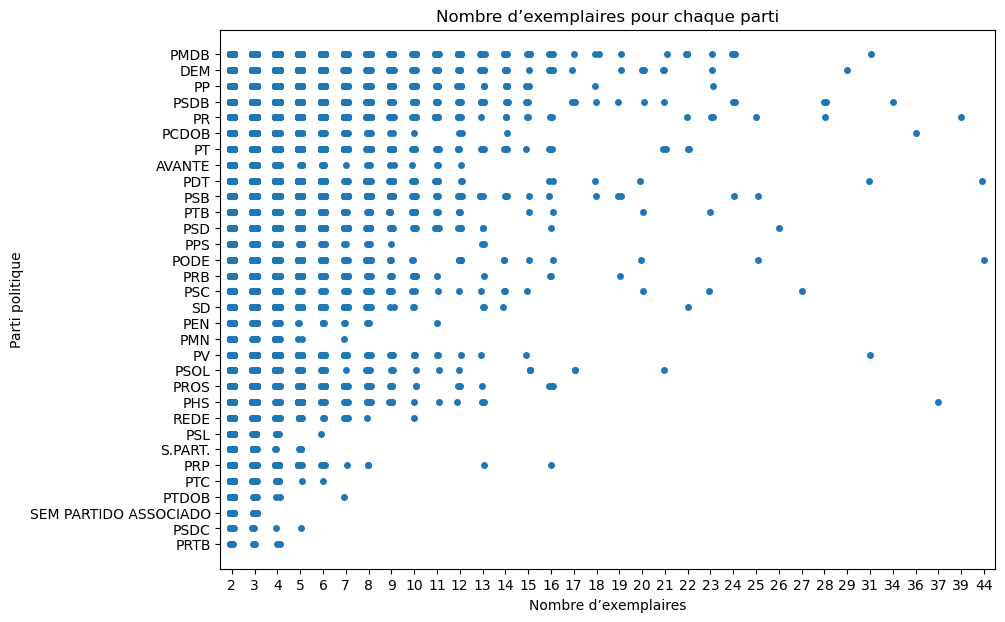

In [74]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
sns.stripplot(data = df.query('nb_exemplaires > 1'), y = 'political_party', x = 'nb_exemplaires', ax = ax, orient = 'v')
ax.set_xlabel('Nombre d’exemplaires')
ax.set_ylabel('Parti politique')
plt.title('Nombre d’exemplaires pour chaque parti', pad = 10);

Le phénomène parait minoritaire mais hélas il semble concerner tous les partis. Vérification…

In [32]:
# Y a-t-il des partis où il n’y a pas eu de factures doublonnées ?

In [52]:
df.groupby('political_party').apply(lambda x: (x.nb_exemplaires == 1).all()).map({True: 'Aucun doublon',
                                                                                 False: 'Au moins un doublon'})

political_party
AVANTE                   Au moins un doublon
DEM                      Au moins un doublon
PCDOB                    Au moins un doublon
PDT                      Au moins un doublon
PEN                      Au moins un doublon
PHS                      Au moins un doublon
PMDB                     Au moins un doublon
PMN                      Au moins un doublon
PODE                     Au moins un doublon
PP                       Au moins un doublon
PPS                      Au moins un doublon
PR                       Au moins un doublon
PRB                      Au moins un doublon
PROS                     Au moins un doublon
PRP                      Au moins un doublon
PRTB                     Au moins un doublon
PSB                      Au moins un doublon
PSC                      Au moins un doublon
PSD                      Au moins un doublon
PSDB                     Au moins un doublon
PSDC                     Au moins un doublon
PSL                      Au moins un do

In [678]:
(
doublons_party := df[df['nb_exemplaires'] > 1].groupby('political_party')\
    .agg({'nb_exemplaires': lambda x : (x -1).sum()}).sort_values(by = 'nb_exemplaires', ascending = False)\
    .rename(columns = {'nb_exemplaires': 'nb_doublons'})
)

,nb_doublons
political_party,
PT,25386
PMDB,19807
PSDB,17295
PP,15473
PR,13986
PSB,12214
DEM,11855
PSD,8263
PDT,5788


In [85]:
doublons_party.index.shape

(32,)

In [ ]:
# Quels sont les partis qui ont le plus de députés pour une période de temps donné ?

In [63]:
(
    partis := df['political_party'].unique()
)

<StringArray>
[                  'PDT',                  'PODE',                    'PR',
                   'PHS',                 'PCDOB',                  'PSDB',
                    'PV',                  'PMDB',                   'DEM',
                   'PSC',                   'PSD',                   'PSB',
                    'PP',                   'PTB',                    'PT',
                    'SD',                  'PSOL',                   'PRB',
                  'PROS',                   'PRP',                   'PPS',
                'AVANTE',                   'PEN',                  'REDE',
                 'PTDOB',                   'PMN',                   'PSL',
                   'PTC',               'S.PART.',                  'PSDC',
                  'PRTB', 'SEM PARTIDO ASSOCIADO']
Length: 32, dtype: string

In [24]:
print(f"Le nombre total de partis est de {len(partis)}.")

Le nombre total de partis est de 32.


In [31]:
df.loc[df['deputy_name'].isin(doublons_depute.iloc[0:20].index), 'political_party'].value_counts()

PT      36958
PSDB    34853
PP      23507
PSB     22856
PR      16085
DEM     15590
PV      10069
PSD      7202
PTB      6794
PHS      5840
Name: political_party, dtype: int64

# Les surfacturations

In [18]:
# Combien y a-t-il de postes de dépenses ?

In [19]:
df['receipt_description'].nunique()

21

In [ ]:
# Quels sont ces 21 postes ?

In [20]:
df['receipt_description'].unique()

array(['Fuels and lubricants.',
       'Dissemination of the Parliamentary Activity.', 'Airline tickets',
       'Telephony', 'Postal Services',
       'Renting of motor vehicles or chartering of boats',
       'Maintenance of Office',
       'Consultancies, Researches and Technical Works.', 'Food and Meals',
       'Hosting, except for the Parliamentary in the Federal District.',
       'Rental or Chartering of Motor Vehicles',
       'Security Service Provided By Specialized Company.',
       'Taxi Service, Toll & Parking', 'Land, Sea or River Tickets',
       'Publication Subscription', 'Renting or Chartering of Aircraft',
       'Leasing or Chartering of Boats',
       'Participation in Course, Lecture or Similar Event',
       'Locomotion, Food and Lodging', 'Acquisition of Office Supplies.',
       'Acquisition or Location of Software for Postal Services'],
      dtype=object)

In [ ]:
# Et combien y a-t-il d’entreprises différentes concernées par ces 21 postes de dépenses ?

In [30]:
df.groupby(['receipt_description'])['establishment_name'].count().to_frame()

,establishment_name
receipt_description,
Acquisition of Office Supplies.,1601
Acquisition or Location of Software for Postal Services,2634
Airline tickets,796697
"Consultancies, Researches and Technical Works.",24062
Dissemination of the Parliamentary Activity.,73132
Food and Meals,212036
Fuels and lubricants.,635534
"Hosting, except for the Parliamentary in the Federal District.",49880
"Land, Sea or River Tickets",3938


In [ ]:
# Je vais comparer chaque montant avec la “valeur maximale raisonnable” pour chaque poste de dépense
# à savoir le troisième quartile augmenté de l’espace interquartile multiplié par 1.5.

In [53]:
premier_quartile = df.groupby('receipt_description')['receipt_value'].transform('quantile', 0.25)
troisieme_quartile = df.groupby('receipt_description')['receipt_value'].transform('quantile', 0.75)
iqr = troisieme_quartile - premier_quartile

maximum = troisieme_quartile + iqr * 1.5

df['outlier'] = df['receipt_value'] > maximum

In [54]:
df

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,nb_exemplaires,periode,minimum,fin_premier_mandat,deb_deuxieme_mandat,maximum,outlier
0,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,44,705,2009-03-18,NaT,NaT,2011-02-21,False
1,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,261,31,705,2009-03-18,NaT,NaT,2011-02-21,False
2,0,2009-11-24,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,16,705,2009-03-18,NaT,NaT,2011-02-21,False
3,0,2010-12-28,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,198,12,705,2009-03-18,NaT,NaT,2011-02-21,False
4,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,308,11,705,2009-03-18,NaT,NaT,2011-02-21,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845639,0,2012-07-28,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,RAMAL,41,1,166,2012-05-19,NaT,NaT,2012-11-01,False
2845640,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,41470063000199,Dissemination of the Parliamentary Activity.,GRÁFICA E EDITORA NORTESUL LTDA,36000,1,166,2012-05-19,NaT,NaT,2012-11-01,True
2845641,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,CELULAR FUNCIONAL,126,1,166,2012-05-19,NaT,NaT,2012-11-01,False
2845642,0,2012-08-01,2481,PMDB,MA,Ricardo Archer,<NA>,Telephony,IMÓVEL FUNCIONAL,273,1,166,2012-05-19,NaT,NaT,2012-11-01,False


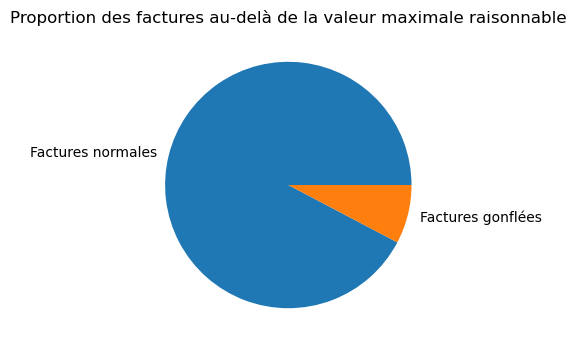

In [55]:
labels = ['Factures normales', 'Factures gonflées']
plt.figure(figsize = (4, 4))
plt.pie(df['outlier'].value_counts(), labels = labels)
plt.title('Proportion des factures au-delà de la valeur maximale raisonnable');

In [80]:
print(f'Le nombre des factures aux montants excessifs est de {df["outlier"].sum()}.')

Le nombre des factures aux montants excessifs est de 165126.


## Surfacturation par entreprise

In [89]:
# Quelles sont les 20 entreprises les plus concernées par ces factures gonflées ?

In [108]:
df

,bugged_date,receipt_date,deputy_id,political_party,state_code,deputy_name,receipt_social_security_number,receipt_description,establishment_name,receipt_value,periode,nb_exemplaires,outlier
119350,0,2009-09-22,1785,PDT,RJ,Arnaldo Vianna,7575651000159,Airline tickets,Cia Aérea - GOL,3,705,44,False
990439,0,2012-12-31,1744,PODE,MG,Ademir Camilo,7575651000159,Airline tickets,Cia Aérea - GOL,106,3128,44,False
1551457,0,2015-02-25,1703,PR,PB,Wellington Roberto,2012862000160,Airline tickets,Cia Aérea - TAM,296,3123,39,False
436531,0,2010-12-27,1332,PHS,AL,Givaldo Carimbão,2012862000160,Airline tickets,Cia Aérea - TAM,336,3125,37,False
436970,0,2010-12-28,1531,PCDOB,BA,Alice Portugal,7575651000159,Airline tickets,Cia Aérea - GOL,218,3162,36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
792386,0,2012-04-08,1729,PT,PI,Nazareno Fonteles,72820822002769,Maintenance of Office,SKY,114,1842,1,False
792385,0,2012-04-08,1710,PT,BA,Zezéu Ribeiro,75021000257,Fuels and lubricants.,AUTO POSTO FLOR DA CHAPADA LTDA,147,1979,1,False
792384,0,2012-04-08,1706,PT,PA,Zé Geraldo,7575651000159,Airline tickets,Cia Aérea - GOL,480,3152,1,False
792383,0,2012-04-08,1693,PSC,PR,Takayama,81894297000420,Fuels and lubricants.,POSTO MARU LTDA,50,3203,1,False


In [92]:
df[df['outlier']].groupby('establishment_name')['outlier'].value_counts().sort_values(ascending = False).head(20)

establishment_name                                       outlier
Cia Aérea - GOL                                          True       11587
Cia Aérea - TAM                                          True       11061
Cia Aérea - AZUL                                         True        1169
TIM                                                      True         821
SÃO JOÃO POSTOS DE ABASTECIMENTOS E SERVIÇOS             True         788
CENTRO DE GESTÃO DE MEIOS DE PAGAMENTOS S/A - SEM PARAR  True         772
VIVO                                                     True         720
SINPETAXI                                                True         665
CENTRO DE GESTÃO DE MEIOS DE PGTO. S/A                   True         634
NEXTEL TELECOMUNICAÇÕES LTDA                             True         534
NEXTEL                                                   True         509
TIM CELULAR S.A                                          True         475
TELEMAR NORTE LESTE S/A                        

La companie Aérea est en tête comme avec les factures dupliquées.

In [ ]:
Mais peut-être cela signifie-t-il que les députés utilisent plus cette compagnie pour voyager…
Quel est le pourcentage de ces montants surfacturés par rapport aux factures des autres companies aériennes

In [107]:
df.groupby('receipt_description').get_group('Airline tickets').groupby('establishment_name').size()\
.sort_values(ascending = False)

establishment_name
Cia Aérea - GOL                     287161
Cia Aérea - TAM                     264632
Cia Aérea - AVIANCA                  63359
Cia Aérea - AZUL                     46284
Cia Aérea - TRIP                      9852
                                     ...  
LINHAS AÉREAS INTELIGENTES-GOL           1
LINHAS AÉREAS INTELIGENTES GOL           1
LINHAS AÉREAS INTELIGENTES - GOL         1
07.575.651/0001-59                       1
02012862000160                           1
Length: 2012, dtype: int64

Déjà on peu dire que la companie Aérea est très utilisée par les députés. Quel est le pourcentage de factures gonflées pour chaque companie ?

In [122]:
df.groupby(['receipt_description']).get_group('Airline tickets')[['establishment_name', 'outlier']]\
/ df.groupby('receipt_description').get_group('Airline tickets').groupby('establishment_name').size()

establishment_name
02012862000160                                    0
07.575.651/0001-59                                0
3R AGÊNCIA DE VEÍCULOS E PASSAGENS AÉREAS LTDA    1
A & S TURISMO E EXCURSÕES LTDA                    1
A J C REPAROS NAVAL LTDA- ME                      1
                                                 ..
ÁQUILA TAXI AÉREO LTDA                            1
ÁQUILA TÁXI AÉREO                                 4
ÁQUILA TÁXI AÉREO LTDA                            2
ÍCARO TÁXI AÉREO LTDA                             1
ÍCARO TÁXI AÉREO LTDA.                            5
Name: outlier, Length: 2012, dtype: int64

## Surfacturation par député

In [93]:
# Et les 20 premiers députés les plus concernés par ces factures “gonflées” ?

In [131]:
df[df['outlier']].groupby('deputy_name')['outlier'].value_counts().droplevel(level = 'outlier')\
.sort_values(ascending = False).head(20)

deputy_name
Givaldo Carimbão            764
Mauro Lopes                 757
Rogério Peninha Mendonça    745
Paulo Pimenta               573
Luiza Erundina              567
Sérgio Moraes               555
Ronaldo Benedet             546
Eduardo Barbosa             536
Vanderlei Macris            521
Zeca Dirceu                 521
Carlos Eduardo Cadoca       504
Leonardo Monteiro           503
Jefferson Campos            503
Edio Lopes                  501
Wladimir Costa              500
Eduardo Sciarra             493
José Carlos Araújo          489
Giacobo                     472
Leonardo Quintão            471
Aelton Freitas              469
Name: outlier, dtype: int64

## Surfacturation par parti

In [96]:
# Les 20 premiers partis les plus concernés par les factures “gonflées” ?

In [133]:
df[df['outlier']].groupby('political_party')['outlier'].value_counts()\
.droplevel('outlier').sort_values(ascending = False).head(20)

political_party
PT       25467
PMDB     23106
PSDB     15331
PP       12487
PSD      11563
PR       11481
DEM      10068
PSB       8276
PDT       6578
PTB       5547
PRB       4840
PCDOB     4216
SD        4196
PSC       3168
PV        3001
PPS       2718
PROS      2281
PODE      1981
PHS       1914
PSOL      1607
Name: outlier, dtype: int64

In [82]:
factures_gonflées_parti = df[df['outlier']].groupby('political_party')['outlier'].value_counts().droplevel(1).sort_values()

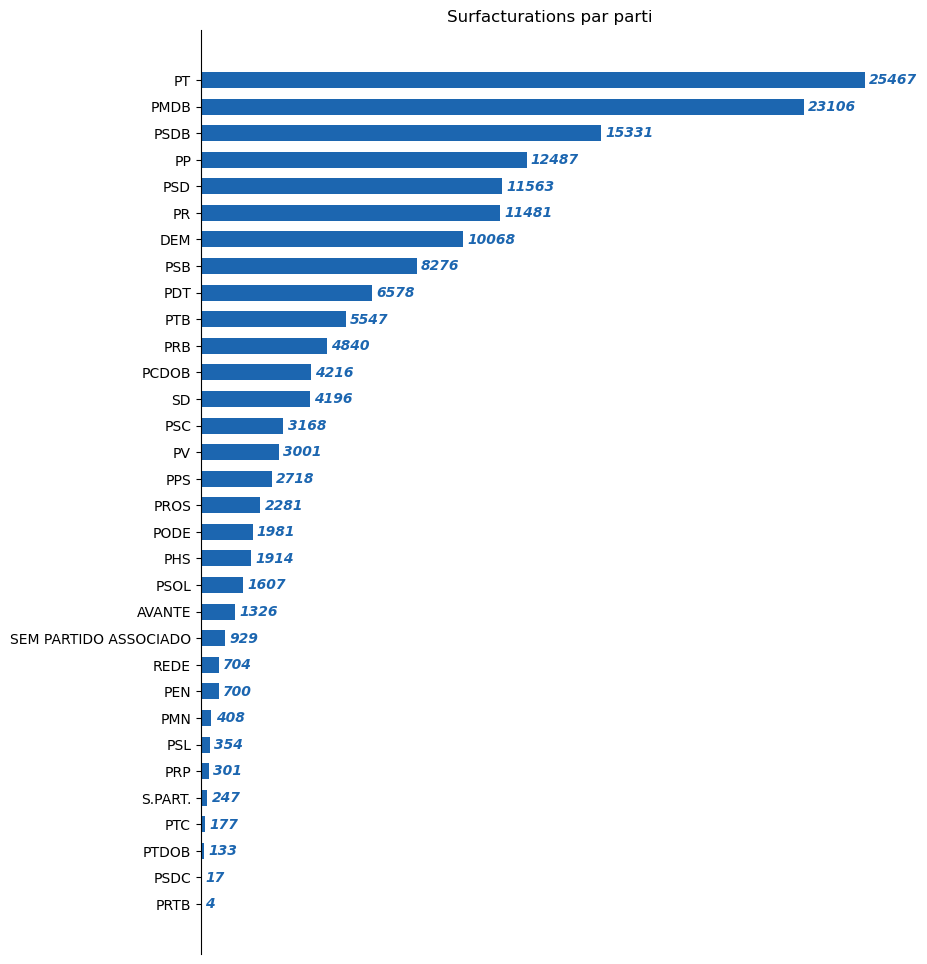

In [95]:
fig, ax = plt.subplots(figsize = (9, 12))
bar = plt.barh(factures_gonflées_parti.index, factures_gonflées_parti.values, height = 0.6, color = '#1c66b0')
ax.spines[['top', 'bottom', 'right']].set_visible(False)
ax.xaxis.set_visible(False)
ax.bar_label(bar, padding = 3, label_type = 'edge', fontstyle = 'italic', color = '#1c66b0', fontweight = 'bold')
plt.title('Surfacturations par parti');

In [ ]:
# Nous avons vu qu’avec le temps, le phénomène s’est tassé.
# Est-ce qu’avec le temps, certains partis ont cessé d’avoir des factures gonflées ?

In [56]:
df_group_political_an = df.groupby(['political_party', pd.Grouper(key = 'receipt_date', freq = 'Y')])

In [61]:
pd.set_option('display.max_rows', 20)
(evolution_outlier_party := df_group_political_an['outlier'].sum() / df_group_political_an.size()).to_frame().rename(columns = {0: 'Pourcentage d’outliers'})

Pourcentage d’outliers
political_party       receipt_date                        
AVANTE                2009-12-31                  0.115512
                      2010-12-31                  0.159091
                      2011-12-31                  0.091316
                      2012-12-31                  0.096462
                      2013-12-31                  0.102058
...                                                    ...
SEM PARTIDO ASSOCIADO 2013-12-31                  0.271226
                      2014-12-31                  0.109290
                      2015-12-31                  0.209402
                      2016-12-31                  0.318442
                      2017-12-31                  0.409742

[256 rows x 1 columns]

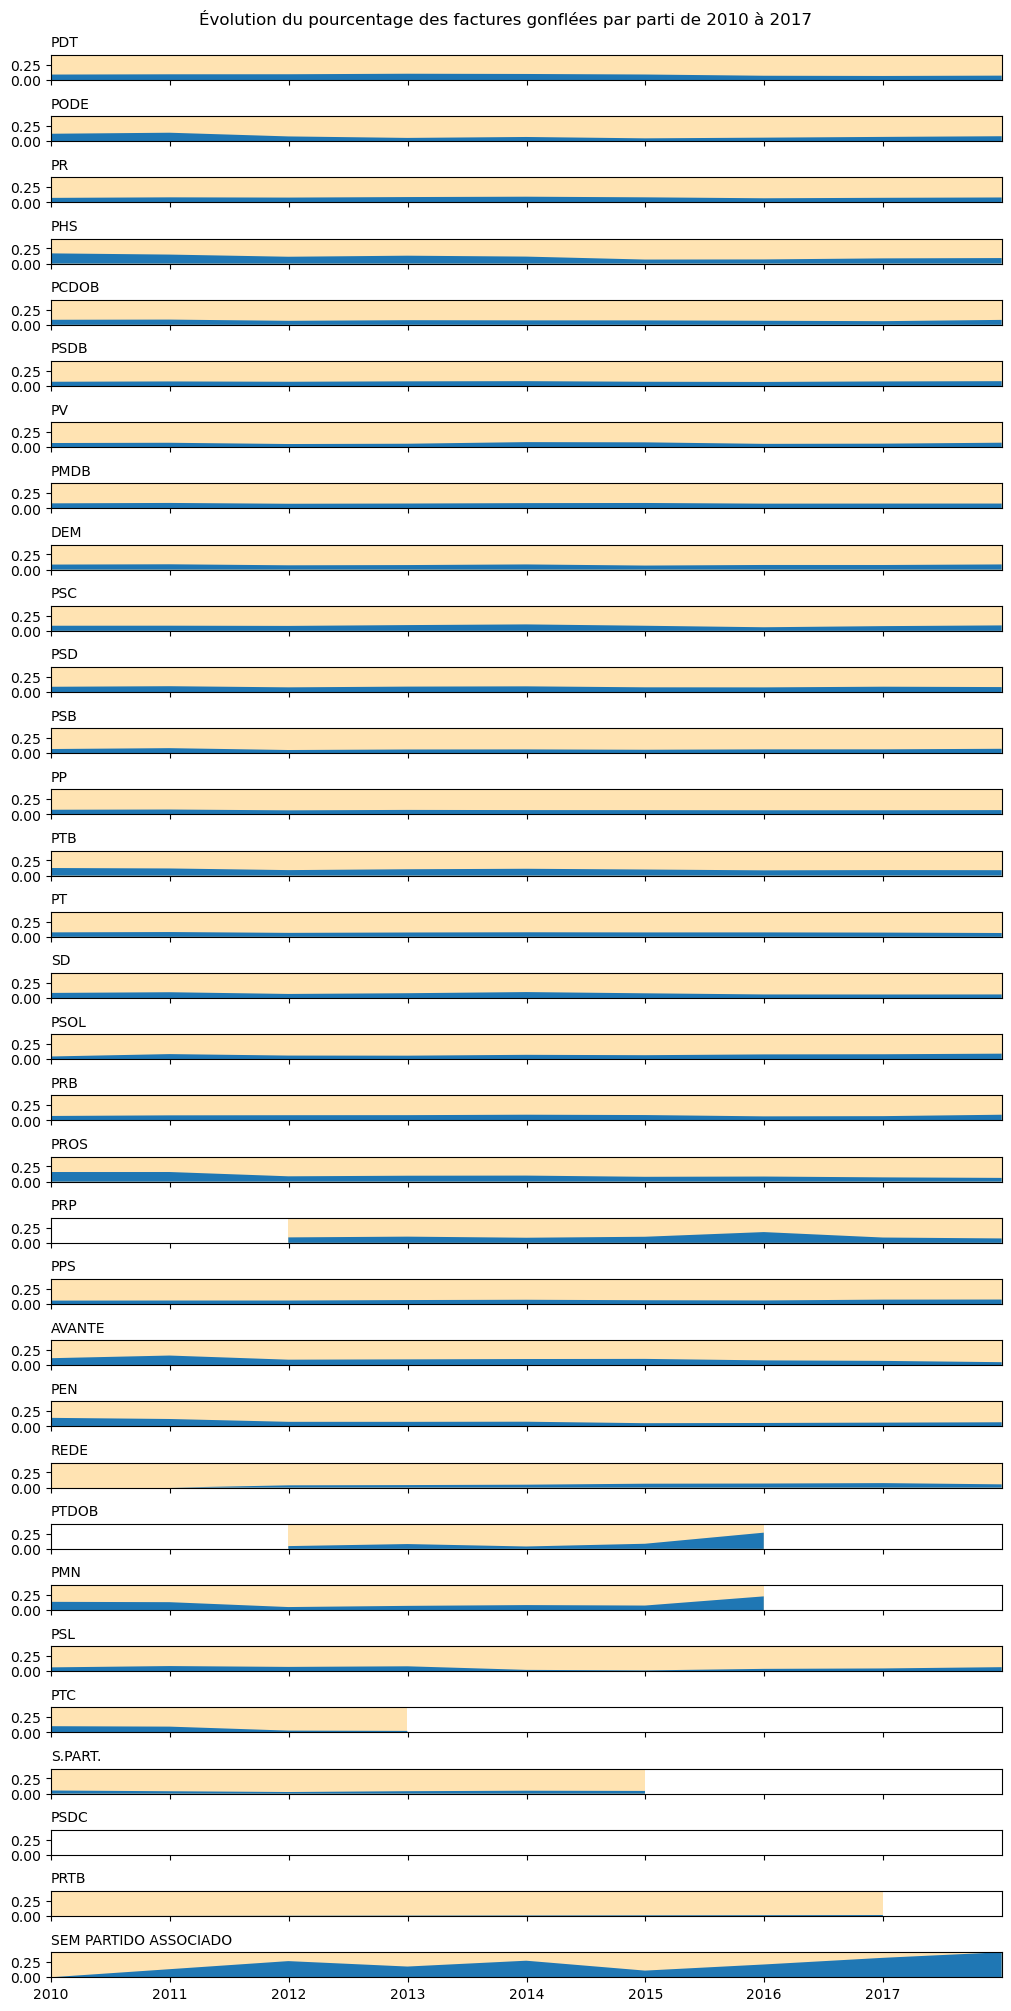

In [67]:
fig, axes = plt.subplots(nrows = len(partis), ncols = 1, figsize = (10, 20), constrained_layout = True,
                         sharex = True, sharey = True)
                         
for axe, parti in zip(axes, partis):
    axe.axvspan(evolution_outlier_party.loc[parti].index.min(), evolution_outlier_party.loc[parti].index.max(),
                facecolor = 'orange', alpha = 0.3)
    axe.fill_between(evolution_outlier_party.loc[parti].index, 0, evolution_outlier_party.loc[parti].values)
    axe.set_title(parti, fontsize = 10, loc = 'left')
plt.suptitle('Évolution du pourcentage des factures gonflées par parti de 2010 à 2017')
plt.margins(0);

# Relation entre les doublons et les surfacturations

In [ ]:
 # Quel est la relation entre les factures dupliquées et les montants excessifs ?

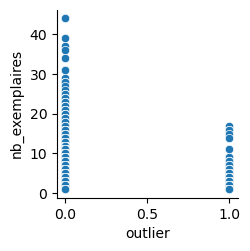

In [99]:
sns.pairplot(data = df, x_vars = 'outlier', y_vars = 'nb_exemplaires');

Les factures qui ne sont pas des “outliers” (des factures au montant surfacturé) semblent avoir été plus dupliquées.

In [ ]:
# Y a-t-il une corrélation entre la valeur d’une facture et le nombre de fois où elle est dupliquée ?

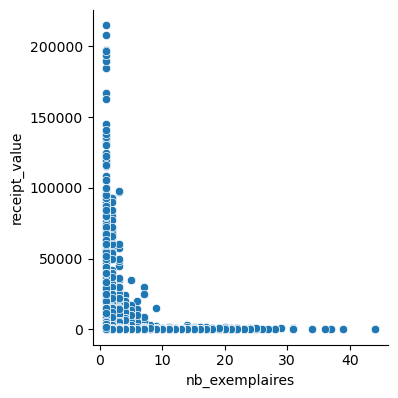

In [81]:
sns.pairplot(data = df, x_vars = 'nb_exemplaires', y_vars = 'receipt_value', height = 4);

In [ ]:
# D’après la figure, il y a au moins une petite corrélation entre le nombre de duplicata et la somme de la facture

# Conclusion

Nous avons vu que les deux problèmes principaux des factures enregistrés par les députés sont les nombreux doublons et les montants excessifs.
Bien que ce double phénomène s’est tassé avec le temps, il reste malgré très important. Cela touche tous les partis à des degrés divers.
Concernant les entreprises, une d’entre elles sort particulièremet du lot que ce soit pour les doublons et les surfacturations : c’est la Compania Aérea.